In [1]:
using JSON
using DataStructures
using Plots
using WebIO
using Interact
using LinearAlgebra
using Statistics
using DelimitedFiles
plotlyjs()
theme(:juno)

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7869729524576452689\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11421060907395925120\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7869729524576452689\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Functions

In [73]:
function remove_periodic_boundary!(array,mini::Integer,maxi::Integer)
    N=length(array)
    shift=maxi-mini+1
    prev=array[1]
    for k in 2:N
        next=array[k]
        
        #enter box to the left
        if prev==mini && next==maxi
            array[k:end].-=shift
            mini-=shift
            maxi-=shift
        #enter box to the right
        elseif prev==maxi && next==mini
            array[k:end].+=shift
            mini+=shift
            maxi+=shift
        end
            
        prev=array[k]
    end
    
    return array
end    



function parse_coords(coords)
    x=Int32[]
    y=Int32[]
    for co in coords
        ii=0
        sym='Σ'
        strX=""
        while sym != '_'
            ii+=1
            sym=co[ii]
            strX*=sym
        end
        strY=""
        while sym != '-'
            ii+=1
            sym=co[ii]
            strY*=sym
        end
        try
            parse(Int32,strX[1:end-1])
            parse(Int32,strY[1:end-1])
        catch
            continue
        end
        
        push!(x,parse(Int32,strX[1:end-1]))
        push!(y,parse(Int32,strY[1:end-1]))
    end
    return (x,y)
end


function get_lP(N_bus,N_R2,avgpoints,mini,maxi,xx,yy)
    minlength=N_R2
    
    R2=zeros(N_R2)
    Z=0
    for bus in 1:N_bus
        x=xx[bus]
        y=yy[bus]
        R=[x.-x[1] y.-y[1]]
        for n in 1:length(x)
            R2[n]+=norm(R[n,:])^2
        end
        
        minlength=min(minlength,length(x))
    end
    
    s=0:N_R2-1
    R2./=N_bus
    i1=minlength-avgpoints
    i2=minlength
    return mean(0.5*R2[i1:i2]./(s[i1:i2]))
end

get_lP (generic function with 1 method)

# data

#### read raw data

In [3]:
datas=OrderedDict{String,Any}[]
file="0.drt_trajectories.json"
for k in 1:15
    path="../../Downloads/DrtShare/09_03_2021/DeltaMax_$(round(1.0+k*0.1;digits=1))/"
    push!(datas,JSON.parsefile(path*file; dicttype=OrderedDict, inttype=Int64, use_mmap=true))
end

#### parse raw data

In [52]:
X=Array{Array{Int,1},2}(undef,15,300)
Y=Array{Array{Int,1},2}(undef,15,300)
mini=0
maxi=50

for k in 1:15
    for bus in 1:300
        dic=collect(datas[k])[bus][2];
        coords_str=collect(values(dic))
        x,y=parse_coords(coords_str)
        remove_periodic_boundary!(x,mini,maxi)
        remove_periodic_boundary!(y,mini,maxi)
        X[k,bus]=x
        Y[k,bus]=y
    end
end

#### write coords data

In [58]:
for k in 1:15
    for bus in 1:300
        writedlm("precalculated/x_$(k)_$(bus).txt",X[k,bus])
        writedlm("precalculated/y_$(k)_$(bus).txt",Y[k,bus])
    end
end

#### read coords data

In [58]:
X=Array{Array{Int,1},2}(undef,15,300)
Y=Array{Array{Int,1},2}(undef,15,300)

for k in 1:15
    for bus in 1:300
        X[k,bus]=readdlm("precalculated/x_$(k)_$(bus).txt")
        Y[k,bus]=readdlm("precalculated/x_$(k)_$(bus).txt")
    end
end

# MSD analysis

#### $l_P$

In [82]:
N_bus=300
N_R2=12000
avgpoints=1000
mini=0
maxi=50
lP=Float64[]

for k in 1:15
    push!(lP,get_lP(N_bus,N_R2,avgpoints,mini,maxi,X[k,:],Y[k,:]))
end

lP

15-element Array{Float64,1}:
 11.994319961448099
 10.70212671012548
  9.252793061448726
  7.282541449828434
  8.646464336601467
  7.578496357655551
  7.026520532988109
  6.933397796715019
  7.136778321587874
  6.711446587144575
  6.402548511660497
  5.684706841407624
  5.5820397096074075
  6.413211926223443
  5.441860378490661

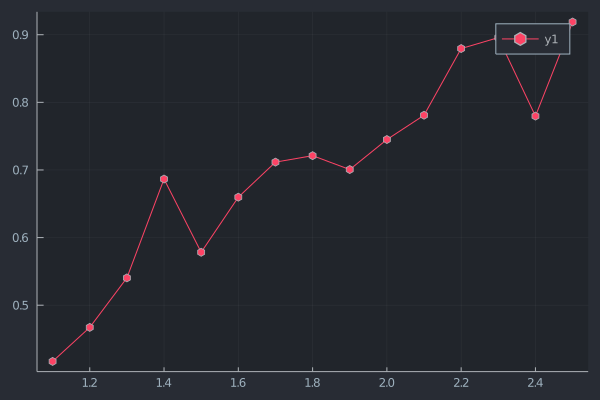

In [84]:
gr()
δ=1.1:0.1:2.5
lP
plot(δ,lP.^-1/0.2,marker=:hex)

In [132]:
R2_15=R2;

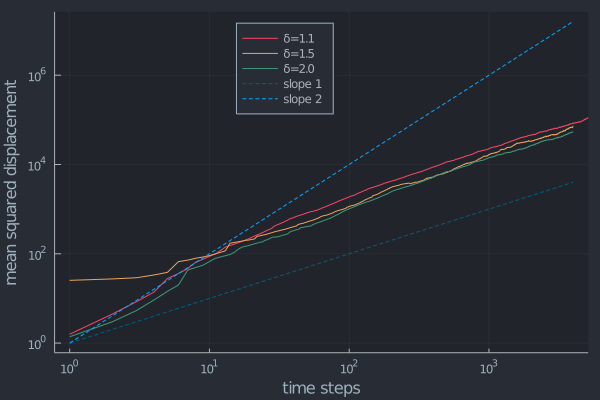

In [133]:
N_R2=8000;s=1:N_R2-1;plot(s,R2_11[2:end],xlim=[1,N_R2],ylim=[1,N_R2^2],legend=:top,xlab="time steps",ylab="mean squared displacement",lab="δ=1.1")
N_R2=4000;s=1:N_R2-1;plot!(s,R2_15[2:end],xlim=[1,N_R2],ylim=[1,N_R2^2],legend=:top,xlab="time steps",ylab="mean squared displacement",lab="δ=1.5")
N_R2=4000;s=1:N_R2-1;plot!(s,R2_20[2:end],xlim=[1,N_R2],ylim=[1,N_R2^2],legend=:top,xlab="time steps",ylab="mean squared displacement",lab="δ=2.0")
plot!(s,s,lab="slope 1",linestyle=:dash)
plot!(s,s.^2,lab="slope 2",linestyle=:dash)
xaxis!(:log);yaxis!(:log)

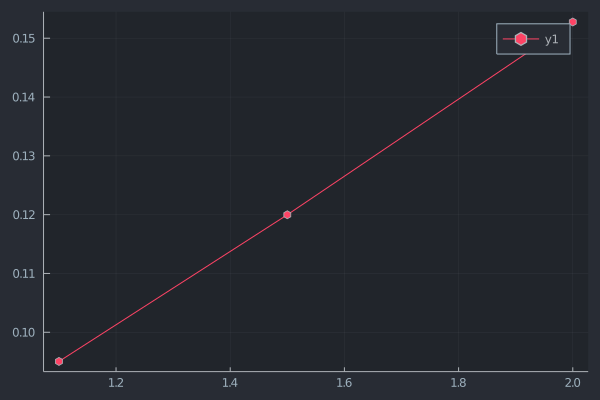

In [145]:
δ=[1.1,1.5,2.0]
lP=[10.521795432976901,8.334507073226911,6.546239892686766]
plot(δ,lP.^-1,marker=:hex)

In [71]:
savefig("MatSim_bus_MSD.html")

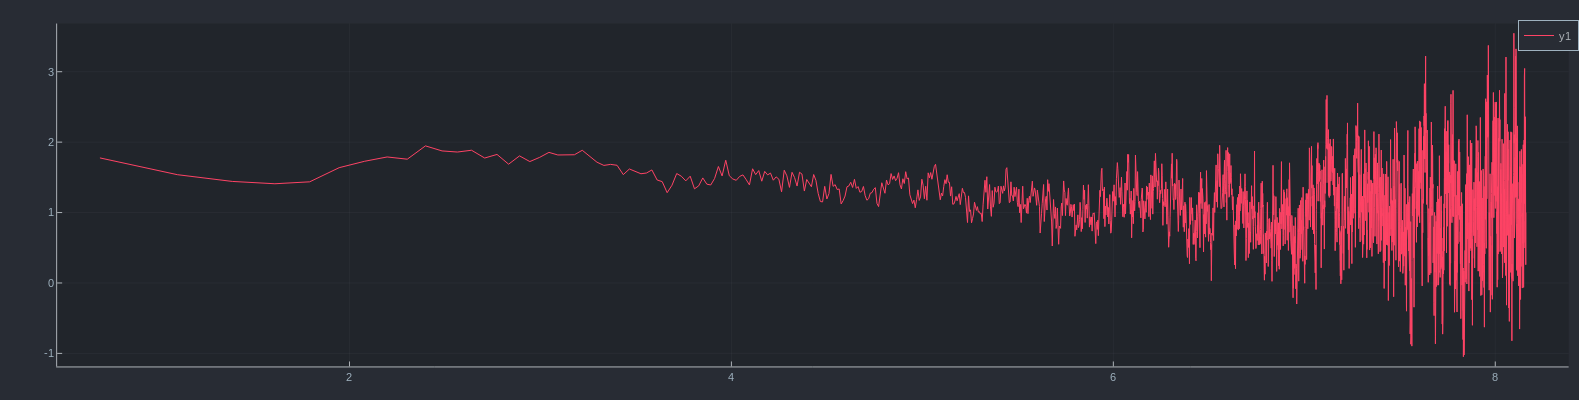

In [179]:
kk=1
Xlog=log.(s_300)
Ylog=log.(R2_300)[2:end]
slope=(Ylog[1+kk:end]-Ylog[1:end-kk])./(Xlog[1+kk:end]-Xlog[1:end-kk])
plot(Xlog[1+kk:end],slope)

# example trajectory

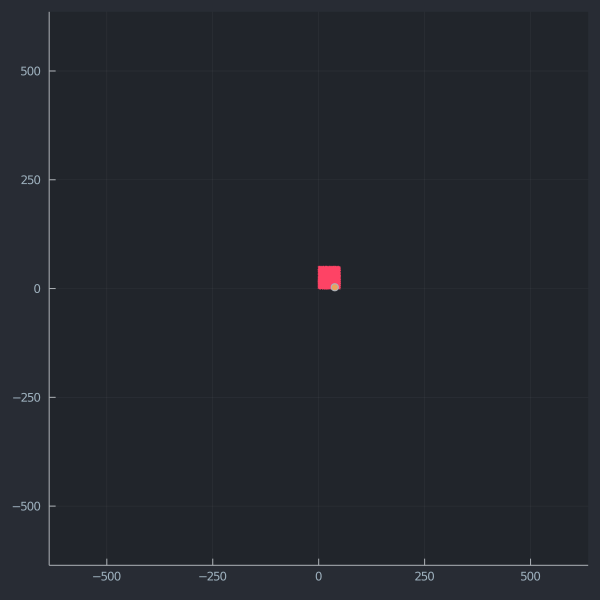

In [82]:
bus=12
dic=collect(dat)[bus][2];
coords_string=collect(values(dic))
x,y=parse_coords(coords_string)

#remove_periodic_boundary!(x,mini,maxi);
#remove_periodic_boundary!(y,mini,maxi);

boxes=6
#x.-=x[1]
#y.-=y[1]
plot(x,y,size=[600,600],xlim=boxes*[-maxi,maxi],ylim=boxes*[-maxi,maxi],legend=:none)
plot!([x[end]],[y[end]],seriestype=:scatter)

In [83]:
println((minimum(x),maximum(x)))
println((minimum(y),maximum(y)))

(0, 50)
(0, 50)


In [82]:
savefig("MatSim_example_trajectory.html")

In [5]:
LENGTH=100
gr()
@manipulate for i in 1:5000
plot(x[i:i+LENGTH],y[i:i+LENGTH],size=[600,600],xlim=[1,100],ylim=[1,100])
plot!([x[i+LENGTH+1]],[y[i+LENGTH+1]],marker=:hex)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 5000,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
2500, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/steffen/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/steffen/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/steffen/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/steffen/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/steffen/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fcd5461e230, Task (runnable) @0x00007fcd5461e230), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"3

In [17]:
using Pkg; Pkg.add("EzXML")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  99.9 %Fetching: [=====>                                   ]  10.2 %>                              ]  22.9 %>                    ]  48.4 % [=========================>               ]  61.3 %Fetching: [===============================>         ]  76.2 %>    ]  88.9 %

  Resolving package versions...
  Installed EzXML ─ v1.1.0
Updating `~/.julia/environments/v1.5/Project.toml`
  [8f5d6c58] + EzXML v1.1.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [8f5d6c58] + EzXML v1.1.0


In [18]:
using EzXML

┌ Info: Precompiling EzXML [8f5d6c58-4d21-5cfd-889c-e3ad7ee6a615]
└ @ Base loading.jl:1278


In [20]:
doc=readxml("../../Downloads/DrtShare/09_03_2021/network_input.xml");

In [23]:
prettyprint(doc)

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v2.dtd">
<network>

<!-- ====================================================================== -->

	<nodes>
		<node id="0_1" x="0.0" y="200.0">
			<attributes>
				<attribute name="isStation" class="java.lang.Boolean">false</attribute>
			</attributes>
		</node>
		<node id="0_10" x="0.0" y="2000.0">
			<attributes>
				<attribute name="isStation" class="java.lang.Boolean">false</attribute>
			</attributes>
		</node>
		<node id="0_10east" x="1.0" y="2000.0">
			<attributes>
				<attribute name="isStation" class="java.lang.Boolean">false</attribute>
			</attributes>
		</node>
		<node id="0_11" x="0.0" y="2200.0">
			<attributes>
				<attribute name="isStation" class="java.lang.Boolean">false</attribute>
			</attributes>
		</node>
		<node id="0_11east" x="1.0" y="2200.0">
			<attributes>
				<attribute name="isStation" class="java.lang.Boolean">false</attribute>
			</attributes>
		</

Excessive output truncated after 524288 bytes.